# pastHistory

Provides information related a patient’s relevant past medical history. Providing detailed past history is not common, but items such as AIDS, Cirrhosis of the Liver, Hepatic Failure, Chronic Renal Failure, Transplant, and Pre-existing Cancers / immunosuppression are more reliable because of their importance in severity outcome scoring.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass

# for configuring connection 
from configobj import ConfigObj
import os

%matplotlib inline

/home/alistairewj/.local/lib/python3.5/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [2]:
# Create a database connection using settings from config file
config='../db/config.ini'

# connection info
conn_info = dict()
if os.path.isfile(config):
    config = ConfigObj(config)
    conn_info["sqluser"] = config['username']
    conn_info["sqlpass"] = config['password']
    conn_info["sqlhost"] = config['host']
    conn_info["sqlport"] = config['port']
    conn_info["dbname"] = config['dbname']
    conn_info["schema_name"] = config['schema_name']
else:
    conn_info["sqluser"] = 'postgres'
    conn_info["sqlpass"] = ''
    conn_info["sqlhost"] = 'localhost'
    conn_info["sqlport"] = 5432
    conn_info["dbname"] = 'eicu'
    conn_info["schema_name"] = 'public,eicu_crd'
    
# Connect to the eICU database
print('Database: {}'.format(conn_info['dbname']))
print('Username: {}'.format(conn_info["sqluser"]))
if conn_info["sqlpass"] == '':
    # try connecting without password, i.e. peer or OS authentication
    try:
        if (conn_info["sqlhost"] == 'localhost') & (conn_info["sqlport"]=='5432'):
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   user=conn_info["sqluser"])            
        else:
            con = psycopg2.connect(dbname=conn_info["dbname"],
                                   host=conn_info["sqlhost"],
                                   port=conn_info["sqlport"],
                                   user=conn_info["sqluser"])
    except:
        conn_info["sqlpass"] = getpass.getpass('Password: ')

        con = psycopg2.connect(dbname=conn_info["dbname"],
                               host=conn_info["sqlhost"],
                               port=conn_info["sqlport"],
                               user=conn_info["sqluser"],
                               password=conn_info["sqlpass"])
query_schema = 'set search_path to ' + conn_info['schema_name'] + ';'

Database: eicu
Username: alistairewj


## Examine a single patient

In [6]:
patientunitstayid = 141168

In [7]:
query = query_schema + """
select *
from pasthistory
where patientunitstayid = {}
order by pasthistoryoffset
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df.head()

,pasthistoryid,patientunitstayid,pasthistoryyear,pasthistorytime24,pasthistorytime,pasthistoryoffset,pasthistoryenteredyear,pasthistoryenteredtime24,pasthistoryenteredtime,pasthistoryenteredoffset,pasthistorynotetype,pasthistorypath,pasthistoryvalue,pasthistoryvaluetext
0,1141834,141168,2015,16:54:00,evening,60,2015,17:06:46,evening,72,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,COPD - no limitations,COPD - no limitations
1,1141830,141168,2015,16:54:00,evening,60,2015,17:06:46,evening,72,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,hypertension requiring treatment,hypertension requiring treatment
2,1141826,141168,2015,16:54:00,evening,60,2015,17:06:46,evening,72,Comprehensive Progress,notes/Progress Notes/Past History/Past History...,Performed,Performed
3,1141829,141168,2015,16:54:00,evening,60,2015,17:06:46,evening,72,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,AICD,AICD
4,1141832,141168,2015,16:54:00,evening,60,2015,17:06:46,evening,72,Comprehensive Progress,notes/Progress Notes/Past History/Organ System...,renal failure- not currently dialyzed,renal failure- not currently dialyzed


We can make a few observations:

* `pasthistorypath` is a slash delimited (`/`) hierarchical categorization of the past history recorded
* `pasthistoryvalue` and `pasthistoryvaluetext` are often identical
* `pasthistoryoffset` is the time of the condition, while `pasthistoryenteredoffset` is when it was documented, though from above it appears the `pasthistoryoffset` is not necessarily the start time of the condition

## Identifying COPD patients

Let's look for patients who were admitted with a past history of COPD.

In [10]:
dx = 'COPD'
query = query_schema + """
select 
  pasthistoryvalue, count(*) as n
from pasthistory
where pasthistoryvalue ilike '%{}%'
group by pasthistoryvalue
""".format(dx)

df_copd = pd.read_sql_query(query, con)
df_copd

,pasthistoryvalue,n
0,COPD - no limitations,13373
1,COPD - moderate,22622
2,COPD - severe,11596


In [11]:
dx = 'COPD'
query = query_schema + """
select 
  patientunitstayid, count(*) as n
from pasthistory
where pasthistoryvalue ilike '%{}%'
group by patientunitstayid
""".format(dx)

df_copd = pd.read_sql_query(query, con)
print('{} unit stays with {}.'.format(df_copd.shape[0], dx))

27123 unit stays with COPD.


## Hospitals with data available

In [12]:
query = query_schema + """
with t as
(
select distinct patientunitstayid
from pasthistory
)
select 
  pt.hospitalid
  , count(distinct pt.patientunitstayid) as number_of_patients
  , count(distinct t.patientunitstayid) as number_of_patients_with_tbl
from patient pt
left join t
  on pt.patientunitstayid = t.patientunitstayid
group by pt.hospitalid
""".format(patientunitstayid)

df = pd.read_sql_query(query, con)
df['data completion'] = df['number_of_patients_with_tbl'] / df['number_of_patients'] * 100.0
df.sort_values('number_of_patients_with_tbl', ascending=False, inplace=True)
df.head(n=10)

,hospitalid,number_of_patients,number_of_patients_with_tbl,data completion
11,73,7059,6050,85.706191
106,264,5237,4863,92.858507
184,420,4679,4467,95.469117
134,338,4277,4222,98.714052
90,243,4243,4093,96.464765
54,167,6092,3779,62.032173
206,458,3701,3623,97.892461
200,443,3656,3589,98.167396
122,300,3617,3544,97.981753
80,208,3650,3403,93.232877


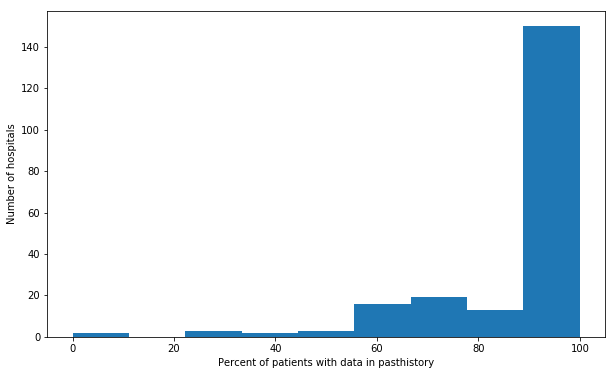

In [13]:
plt.figure(figsize=[10,6])
plt.hist(df['data completion'], bins=np.linspace(0, 100, 10))
plt.xlabel('Percent of patients with data in pasthistory')
plt.ylabel('Number of hospitals')
plt.show()

The majority of hospitals have data for the pasthistory table, again likely due to its importance for certain severity of illness scoring systems.